In [1]:
import numpy as np
import pandas as pd 
import tensorflow as tf
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
import re
import string
import unicodedata
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
stop_words = set(stopwords.words('english'))
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import seaborn as sns

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vassi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In order to download the 'train.csv' and 'test.csv' files, follow the link: https://drive.google.com/drive/folders/1GtFMaqWYieUR9A6D3gO_u8QjsBVkIi8H?usp=sharing

In [2]:
location = 'C:/Users/vassi/Desktop/'
train = pd.read_csv(location+'train.csv')
test = pd.read_csv(location+'test.csv')
# train = train[~((train['toxic'] == 0) & (train['severe_toxic'] == 0) & (train['obscene'] == 0) & (train['threat'] == 0) & (train['insult'] == 0) & (train['identity_hate'] == 0))]
# train = train[train['toxic'] != 0]
# train = train.drop(['toxic'], axis=1)
train = train.reset_index().drop(['index', 'id'], axis=1)
test = test.reset_index()

In [3]:
def remove_stopwords(text):
    sw_nltk = stopwords.words('english')
    sw_nltk.append('st')
    sw_nltk.append('nd')
    sw_nltk.append('rd')
    sw_nltk.append('th')
    sw_nltk.append('rt')
    words = [word for word in text.split() if word.lower() not in sw_nltk]
    new_text = " ".join(words)
    return new_text

def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation'''
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    text = ''.join(i for i in text if not i.isdigit())
    return text

In [4]:
# delete nan messages and clean the messages

train=train[~train['comment_text'].isna()]
train['comment_text']=train['comment_text'].apply(lambda x: clean_text(x))
#remove empty comments and stopwords
train = train[~train['comment_text'].isin(['', ' ', np.nan, None, []])]
train['comment_text']=train['comment_text'].apply(lambda x: remove_stopwords(x))

#remove empty comments after the removal of stopwords
train = train[~train['comment_text'].isin(['', ' ', np.nan, None, []])]

In [5]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

text_toxic = " ".join(review for review in train[train['toxic'] == 1].comment_text)
wc_toxic = WordCloud(collocations=False, background_color='white', colormap='cool').generate(text_toxic)
text_general = " ".join(review for review in train.comment_text)
wc_general = WordCloud(collocations=False, background_color='white', colormap='Dark2').generate(text_general)

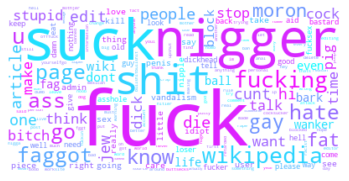

In [6]:
plt.figure()
plt.imshow(wc_toxic, interpolation="bilinear")
plt.axis("off")
plt.show()

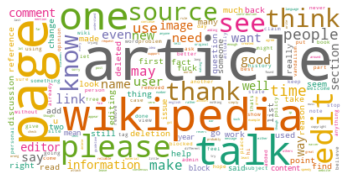

In [7]:
plt.figure()
plt.imshow(wc_general, interpolation="bilinear")
plt.axis("off")
plt.show()

In [8]:
X_train, X_test = train_test_split(train, random_state=420, test_size=0.2, shuffle=True)
y_train = X_train.drop(['comment_text'],axis=1)
X_train = X_train.comment_text
y_test = X_test.drop(['comment_text'],axis=1)
X_test = X_test.comment_text

In [9]:
df_toxic = train.drop(['comment_text'], axis=1)
counts = []
categories = list(df_toxic.columns.values)

In [36]:
# Define a pipeline combining a text feature extractor with multi lable classifier

NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])
# train the model using X_dtm & y
NB_pipeline.fit(X_train, y_train)
# compute the testing accuracy
prediction = NB_pipeline.predict(X_test)
prediction = pd.DataFrame(prediction, columns=y_test.columns)
print('Test accuracy is {}'.format(accuracy_score(y_test, prediction)))

Test accuracy is 0.9001473492804966


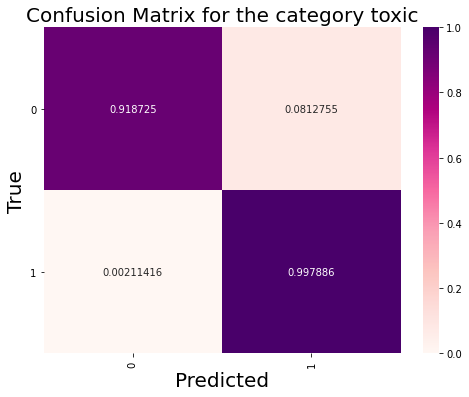

<ipython-input-55-4973dbef133e>:9: RuntimeWarning: invalid value encountered in true_divide
  cm1 = cm2.astype('float') / cm2.sum(axis=1)[:, np.newaxis]


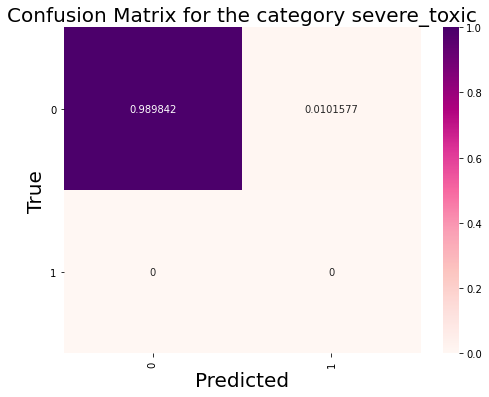

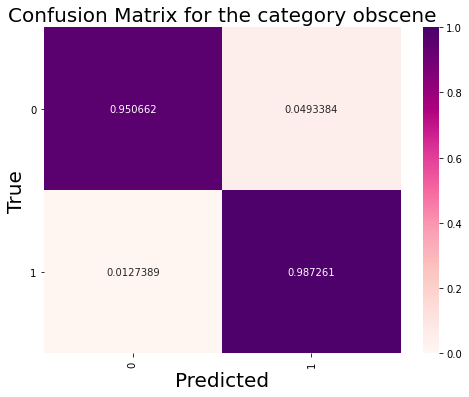

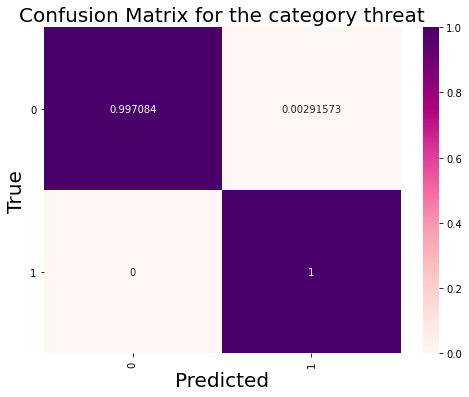

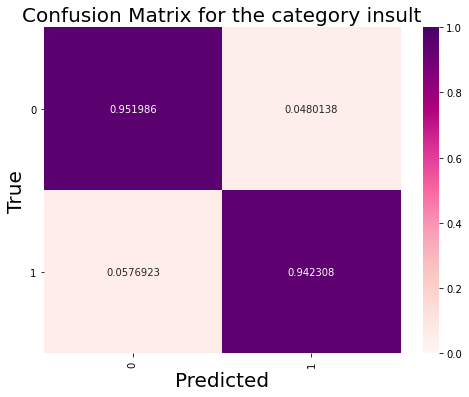

<ipython-input-55-4973dbef133e>:9: RuntimeWarning: invalid value encountered in true_divide
  cm1 = cm2.astype('float') / cm2.sum(axis=1)[:, np.newaxis]


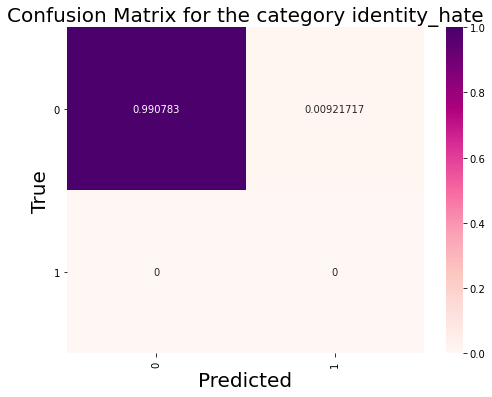

In [55]:
from sklearn.metrics import confusion_matrix

for category in list(y_test.columns):
    cm2=confusion_matrix(prediction[category],y_test[category])

    # Plot confusion matrix in a beautiful manner
    fig = plt.figure(figsize=(8, 6))
    ax= plt.subplot()
    cm1 = cm2.astype('float') / cm2.sum(axis=1)[:, np.newaxis]
    cm1 = np.nan_to_num(cm1, nan=0)
    sns.heatmap(cm1, annot=True, ax = ax, fmt = 'g',cmap='RdPu',vmax=1,vmin=0); #annot=True to annotate cells
    # labels, title and ticks
    ax.set_xlabel('Predicted', fontsize=20)
    ax.xaxis.set_label_position('bottom')
    plt.xticks(rotation=90)
    ax.xaxis.tick_bottom()

    ax.set_ylabel('True', fontsize=20)
    plt.yticks(rotation=0)

    plt.title('Confusion Matrix for the category {}'.format(category), fontsize=20)


    plt.show()

In [56]:
SVC_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),
            ])

# train the model using X_dtm & y
SVC_pipeline.fit(X_train, y_train)
# compute the testing accuracy
prediction = SVC_pipeline.predict(X_test)
prediction = pd.DataFrame(prediction, columns=y_test.columns)
print('Test accuracy is {}'.format(accuracy_score(y_test, prediction)))

Test accuracy is 0.918895193905383


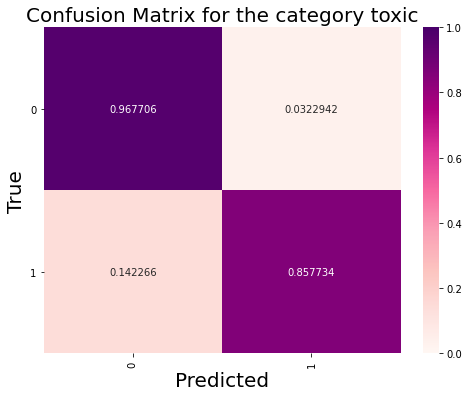

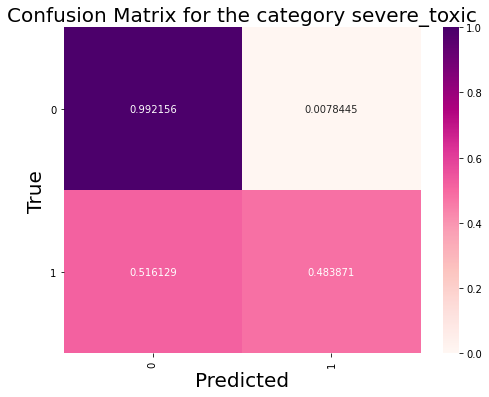

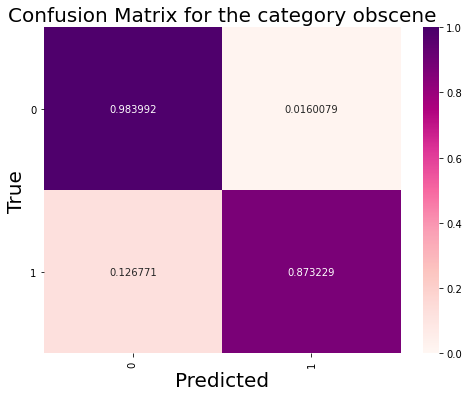

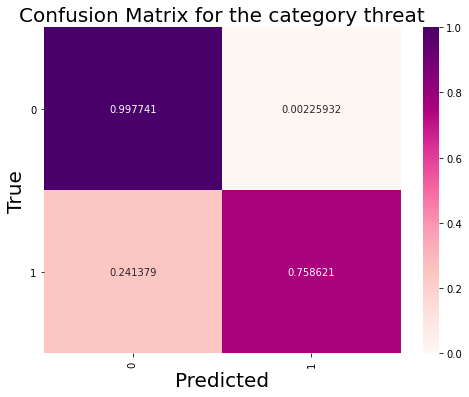

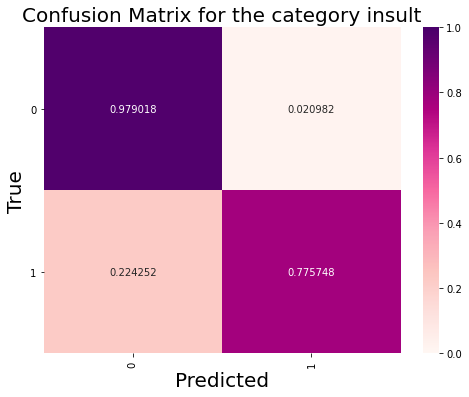

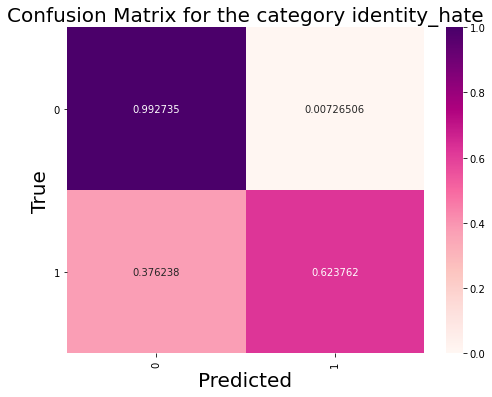

In [57]:
for category in list(y_test.columns):
    cm2=confusion_matrix(prediction[category],y_test[category])

    # Plot confusion matrix in a beautiful manner
    fig = plt.figure(figsize=(8, 6))
    ax= plt.subplot()
    cm1 = cm2.astype('float') / cm2.sum(axis=1)[:, np.newaxis]
    cm1 = np.nan_to_num(cm1, nan=0)
    sns.heatmap(cm1, annot=True, ax = ax, fmt = 'g',cmap='RdPu',vmax=1,vmin=0); #annot=True to annotate cells
    # labels, title and ticks
    ax.set_xlabel('Predicted', fontsize=20)
    ax.xaxis.set_label_position('bottom')
    plt.xticks(rotation=90)
    ax.xaxis.tick_bottom()

    ax.set_ylabel('True', fontsize=20)
    plt.yticks(rotation=0)

    plt.title('Confusion Matrix for the category {}'.format(category), fontsize=20)


    plt.show()

In [10]:
LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
            ])

# train the model using X_dtm & y
LogReg_pipeline.fit(X_train, y_train)
# compute the testing accuracy
prediction = LogReg_pipeline.predict(X_test)
prediction = pd.DataFrame(prediction, columns=y_test.columns)
print('Test accuracy is {}'.format(accuracy_score(y_test, prediction)))

Test accuracy is 0.919647615763238


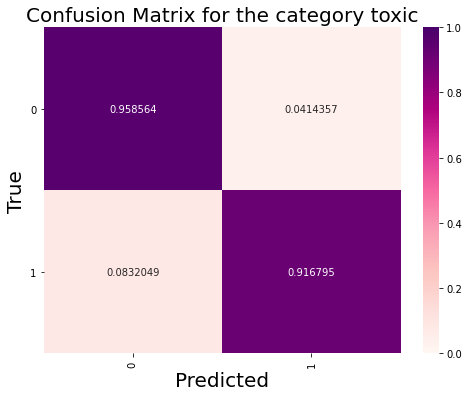

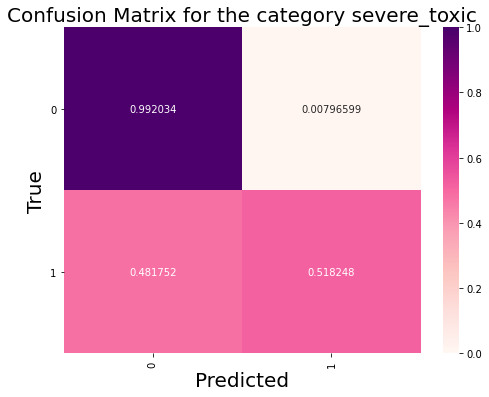

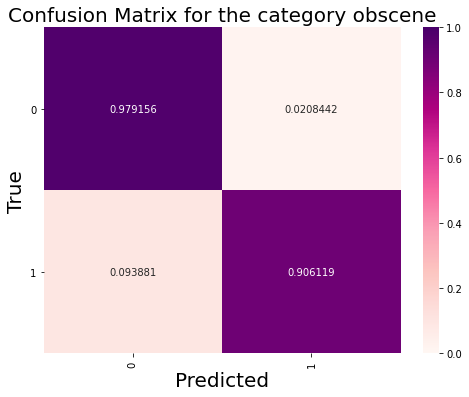

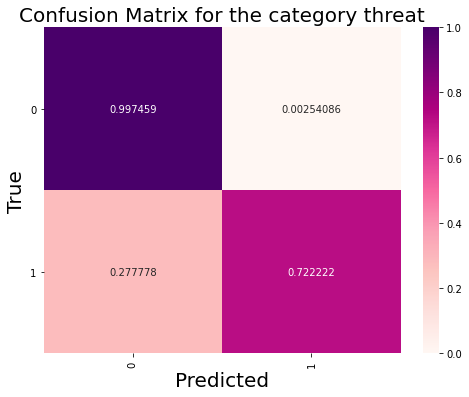

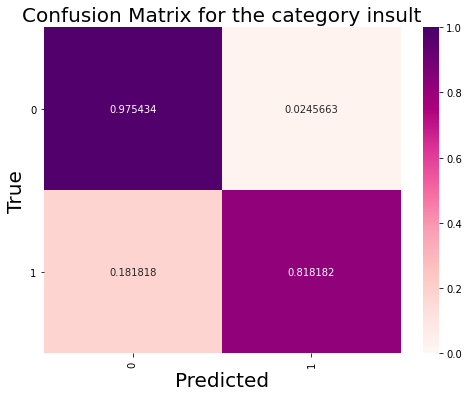

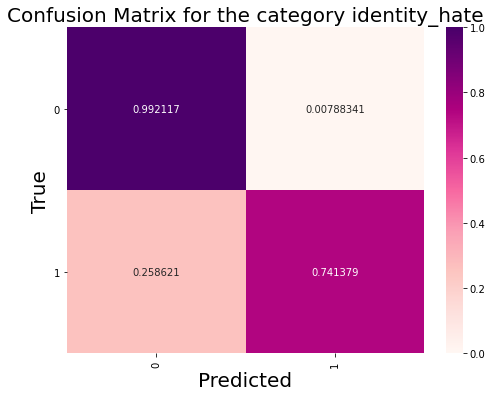

In [59]:
for category in list(y_test.columns):
    cm2=confusion_matrix(prediction[category],y_test[category])

    # Plot confusion matrix in a beautiful manner
    fig = plt.figure(figsize=(8, 6))
    ax= plt.subplot()
    cm1 = cm2.astype('float') / cm2.sum(axis=1)[:, np.newaxis]
    cm1 = np.nan_to_num(cm1, nan=0)
    sns.heatmap(cm1, annot=True, ax = ax, fmt = 'g',cmap='RdPu',vmax=1,vmin=0); #annot=True to annotate cells
    # labels, title and ticks
    ax.set_xlabel('Predicted', fontsize=20)
    ax.xaxis.set_label_position('bottom')
    plt.xticks(rotation=90)
    ax.xaxis.tick_bottom()

    ax.set_ylabel('True', fontsize=20)
    plt.yticks(rotation=0)

    plt.title('Confusion Matrix for the category {}'.format(category), fontsize=20)


    plt.show()

In [67]:
from sklearn.ensemble import RandomForestClassifier

RanFor_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(RandomForestClassifier(), n_jobs=1)),
            ])

# train the model using X_dtm & y
RanFor_pipeline.fit(X_train, y_train)
# compute the testing accuracy
prediction = RanFor_pipeline.predict(X_test)
prediction = pd.DataFrame(prediction, columns=y_test.columns)
print('Test accuracy is {}'.format(accuracy_score(y_test, prediction)))

Test accuracy is 0.9062294259648243


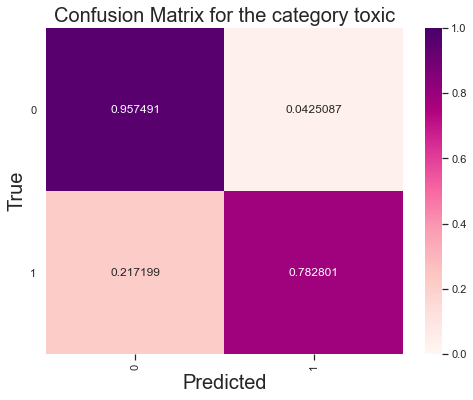

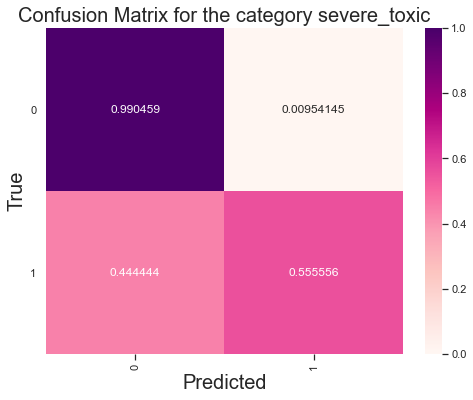

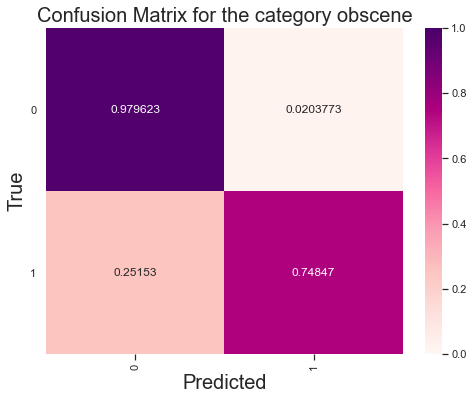

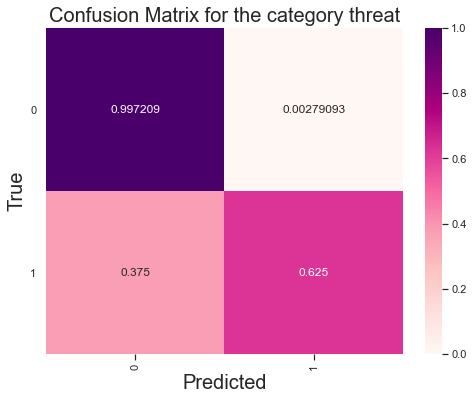

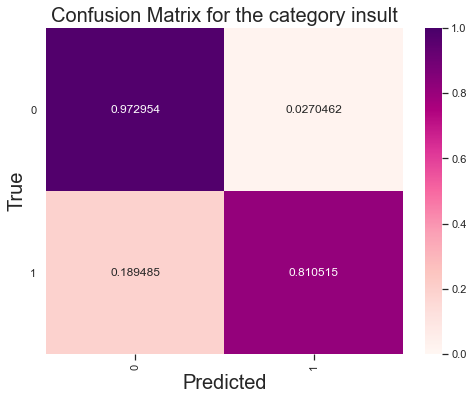

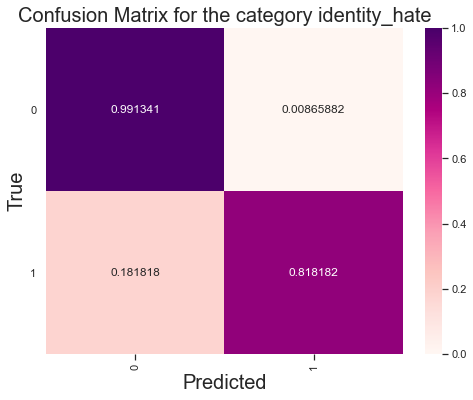

In [68]:
for category in list(y_test.columns):
    cm2=confusion_matrix(prediction[category],y_test[category])

    # Plot confusion matrix in a beautiful manner
    fig = plt.figure(figsize=(8, 6))
    ax= plt.subplot()
    cm1 = cm2.astype('float') / cm2.sum(axis=1)[:, np.newaxis]
    cm1 = np.nan_to_num(cm1, nan=0)
    sns.heatmap(cm1, annot=True, ax = ax, fmt = 'g',cmap='RdPu',vmax=1,vmin=0); #annot=True to annotate cells
    # labels, title and ticks
    ax.set_xlabel('Predicted', fontsize=20)
    ax.xaxis.set_label_position('bottom')
    plt.xticks(rotation=90)
    ax.xaxis.tick_bottom()

    ax.set_ylabel('True', fontsize=20)
    plt.yticks(rotation=0)

    plt.title('Confusion Matrix for the category {}'.format(category), fontsize=20)


    plt.show()

In [5]:
# questionnaire data

data = pd.read_csv(location + 'Video+Games+for+Research_+Rating+toxicity_April+3,+2022_09.33.csv')
data = data.drop([0, 1], axis=0).reset_index()
data = data.drop(['index', 'StartDate', 'EndDate', 'Status', 'IPAddress', 'Progress', 'Duration (in seconds)', 'Finished', 'RecordedDate', 'ResponseId', 'RecipientLastName', 'RecipientLastName', 'RecipientFirstName', 'RecipientEmail', 'ExternalReference', 'LocationLatitude', 'LocationLongitude', 'DistributionChannel', 'UserLanguage', 'Consent'], axis=1)
columns = data.columns
columns = columns.drop(['Q25'])
swap_classes = {'6': '0'}
data['Introduction + Q1'] = data['Introduction + Q1'].fillna(99)
data = data[data['Introduction + Q1'] != 99]
length = len(data)
key = list(swap_classes.keys())[0]

# convert the classes from strings to lists of integers to prepare for the testing phase

for column in columns:
    data[column] = data[column].str.replace(key, swap_classes[key])
    for row in range(length):
        l = data[column].iloc[row].split(',')
        l = [int(x) for x in l]
        data[column].iloc[row] = l

In [6]:
# create a dataframe and a dictionary with the questions of the questionnaire

questions = pd.DataFrame(columns=['Question ID', 'Question'])
questions['Question ID'] = data.columns
questions['Question'] = ['Do you play League of Legends (or any similar game)?', 'You are a fucking worthless braindead scumfuck bastard pile of trash mental'+'\n'+'dickface that should be gunned down in the street like the degenerate you are', 
                         'Fucking French', "How much dick u sucked for boost u slut, i'd rape you better than give you play:", "gg ez (good game, easy)", "Uninstall pls",
                         "Kys (Kill yourself)", "Noob", "fuck", "stfu", "Idiot", "Retard", "get cancer", "better jungle wins", 
                         "I hope there's no milk the next time you want cereal", "Step on a lego", "Die in a fire", "You're an abortion gone wrong", "Trash", 
                         "...fed, please report for feeding", "Reported", "Why don't you get a life you sicko.", "I will hunt you down and kill you, you useless piece of shit", 
                         "Hey bitch why'd you create a gay ass site like this? Deadfuck.", "If you have experienced toxicity in game before (and if you can remember), please write down what people have said to you."]
dict_questions = questions.set_index('Question ID').to_dict()['Question']

final_questions = pd.DataFrame(dict_questions.values(), index=list(dict_questions.keys()), columns=['comment_text']).iloc[1:-1]['comment_text']

In [7]:
# a function that returns the final decision for the representing classes (ones that have a frequency greater than a random choice 1/num(classes))
# and the corresponding frequencies

def mean_of_classes(data):
    columns = list(data.columns)
    final_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
    length = len(final_columns)
    final = pd.DataFrame(columns=final_columns)
    l = []
    dictionaries = []
    for column in columns:
        exploded = list(data.explode(column)[column])
        dictionary = dict(collections.Counter(exploded))
        for key in range(6):
            if key not in list(dictionary.keys()):
                dictionary[key] = 0
        dictionary = dict(collections.OrderedDict(sorted(dictionary.items())))
        mean = int(sum(list(dictionary.values()))/len(dictionary))
        keep = [1 if value >= mean else 0 for key, value in dictionary.items()]
        l.append(keep)
        dictionaries.append(dictionary)
    return pd.DataFrame(l,columns=final_columns), dictionaries

In [8]:
import collections

questionnaire_data = data.drop([data.columns[0], data.columns[-1]], axis=1)
columns = list(data.columns)[1:-1]
for column in columns:
    dataset, dictionary = mean_of_classes(questionnaire_data)
dataset.index = data.columns[1:-1]
dataset['toxic'] = dataset['toxic'].apply(lambda x: 1 - x)

In [9]:
def similarity(a, b):
    sim = 0
    for i in range(len(a)):
        if a[i] == b[i]:
            sim += 1
    return sim/len(a)

In [10]:
# apply the trained model for the testing phase

from numpy import dot
from numpy.linalg import norm

prediction = LogReg_pipeline.predict(final_questions)
prediction = pd.DataFrame(prediction, columns=dataset.columns, index=list(dict_questions.keys())[1:-1])
acc = 0
columns = list(prediction.columns)
length = len(columns)
sim = 0
for column in columns:
    acc += accuracy_score(dataset[column], prediction[column])
for i in range(len(prediction)):
    sim += similarity(prediction.iloc[i], dataset.iloc[i])
print('Test accuracy is {}.'.format(acc/length))
print('Similarity is {}.'.format(sim/len(prediction)))

NameError: name 'LogReg_pipeline' is not defined

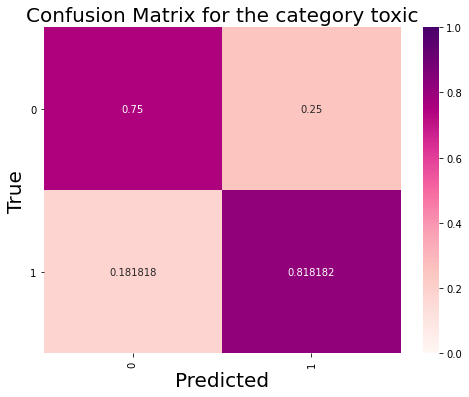

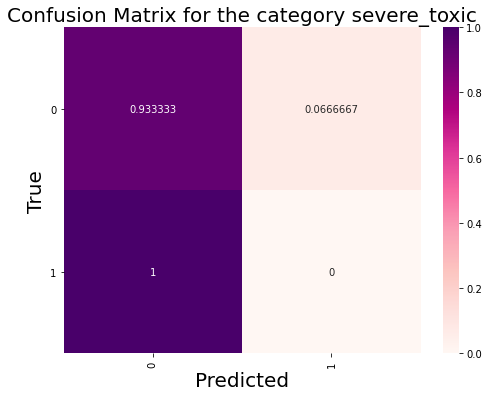

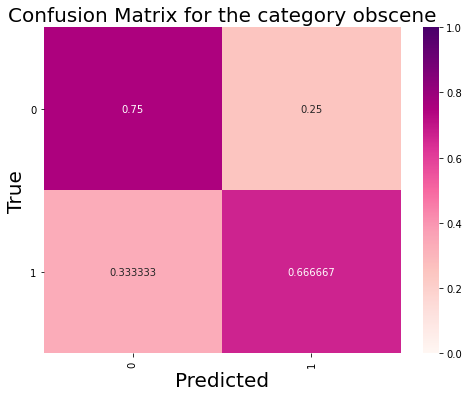

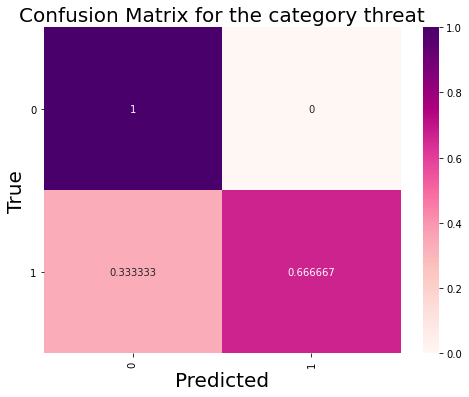

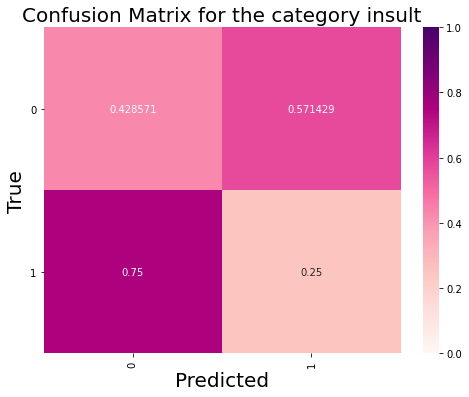

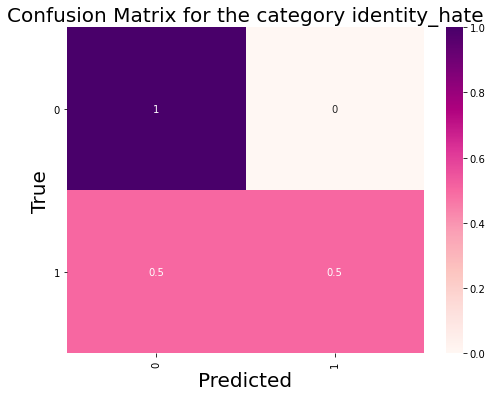

In [47]:
from sklearn.metrics import confusion_matrix

for column in columns:    
    
    cm2=confusion_matrix(dataset[column],prediction[column])

    # Plot confusion matrix in a beautiful manner
    fig = plt.figure(figsize=(8, 6))
    ax= plt.subplot()
    cm1 = cm2.astype('float') / cm2.sum(axis=1)[:, np.newaxis]
    cm1 = np.nan_to_num(cm1, nan=0)
    sns.heatmap(cm1, annot=True, ax = ax, fmt = 'g',cmap='RdPu',vmax=1,vmin=0); #annot=True to annotate cells
    # labels, title and ticks
    ax.set_xlabel('Predicted', fontsize=20)
    ax.xaxis.set_label_position('bottom')
    plt.xticks(rotation=90)
    ax.xaxis.tick_bottom()

    ax.set_ylabel('True', fontsize=20)
    plt.yticks(rotation=0)

    plt.title('Confusion Matrix for the category {}'.format(column), fontsize=20)


    plt.show()

In [48]:
# function that returns the percentage of people who voted for a predicted class

import dataframe_image as dfi

def percentages(prediction, questions):
    indexes = list(prediction.index)
    percentage = []
    for i in range(len(indexes)):
        s = sum(questions[i].values())
        l = ["{:.2f}".format(questions[i][list(questions[i].keys())[j]]/s*100) + '%' if prediction.loc[indexes[i]][j] == 1 else '-' for j in range(len(prediction.loc[indexes[i]]))]
        percentage.append(l)
    return pd.DataFrame(percentage, columns=list(prediction.columns), index=indexes)

percentage = percentages(prediction, dictionary)
dfi.export(percentage, location + 'Percentages.png')

C:\Users\vassi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


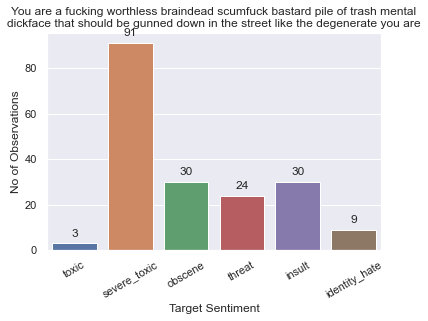

C:\Users\vassi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


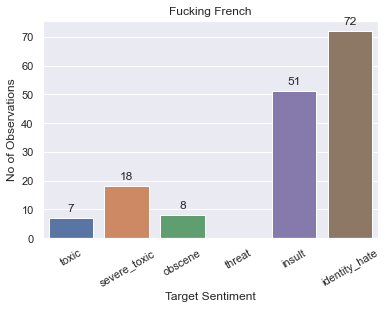

C:\Users\vassi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


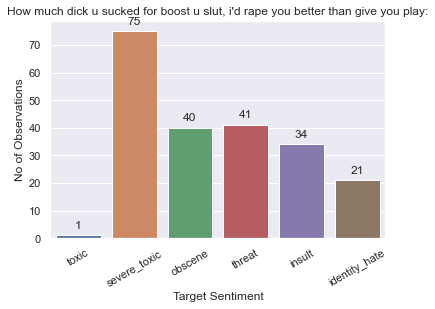

C:\Users\vassi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


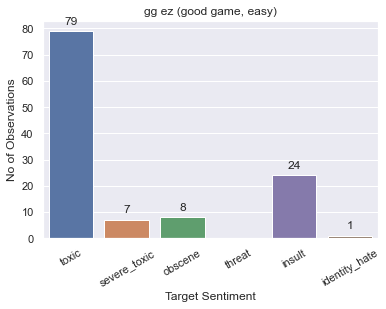

C:\Users\vassi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


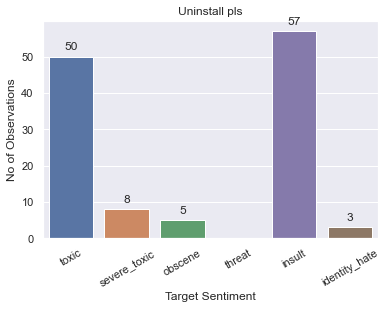

C:\Users\vassi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


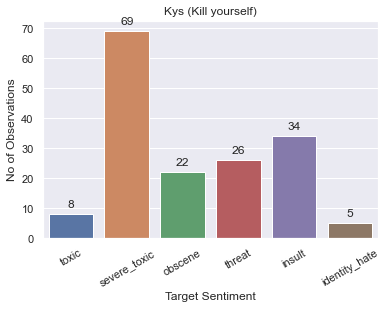

C:\Users\vassi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


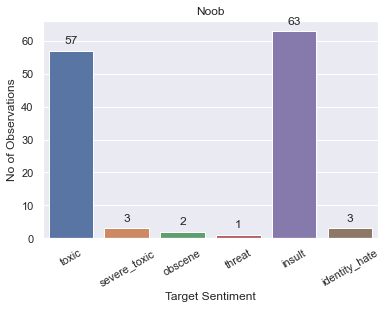

C:\Users\vassi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


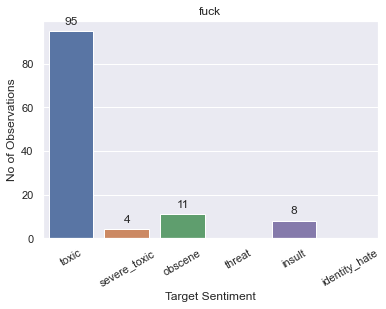

C:\Users\vassi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


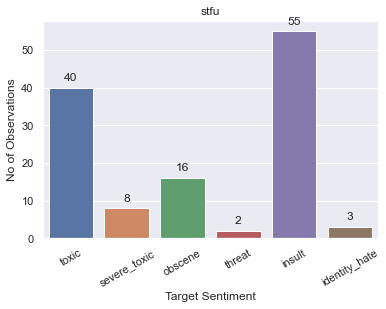

C:\Users\vassi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


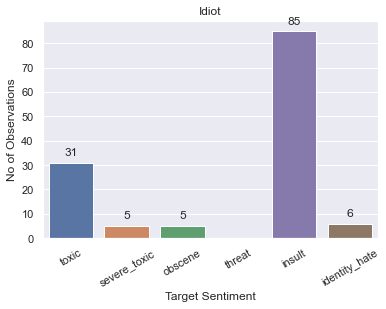

C:\Users\vassi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


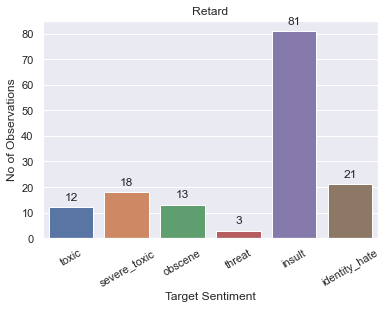

C:\Users\vassi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


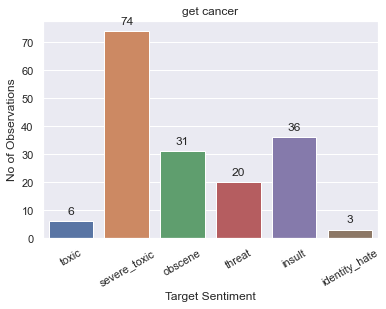

C:\Users\vassi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


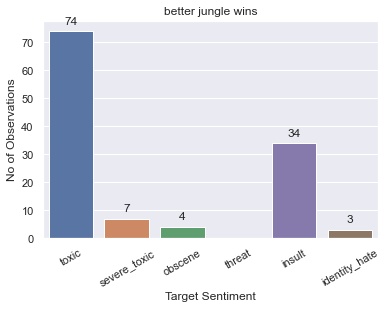

C:\Users\vassi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


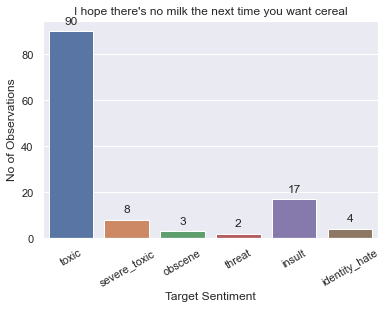

C:\Users\vassi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


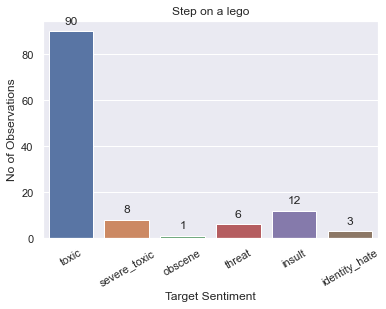

C:\Users\vassi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


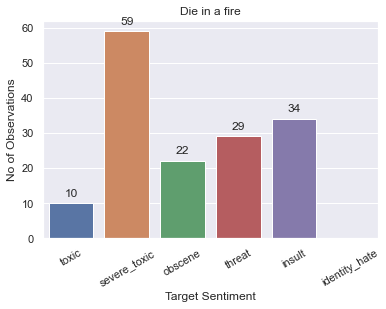

C:\Users\vassi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


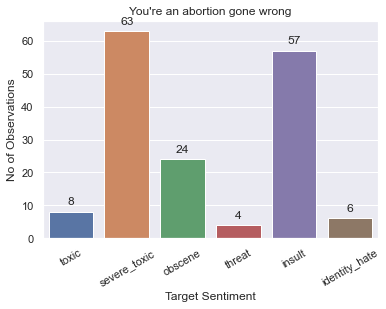

C:\Users\vassi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


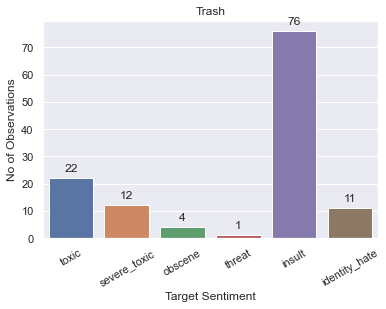

C:\Users\vassi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


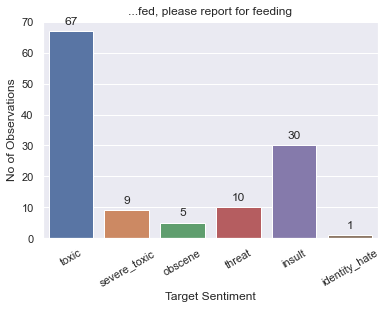

C:\Users\vassi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


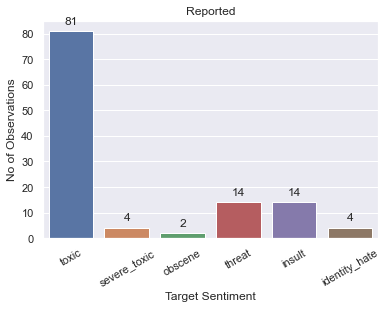

C:\Users\vassi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


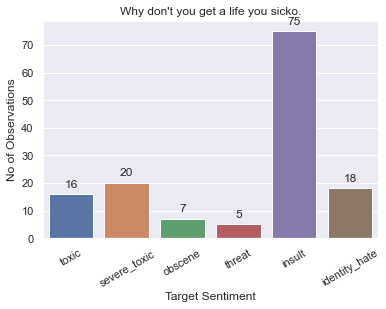

C:\Users\vassi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


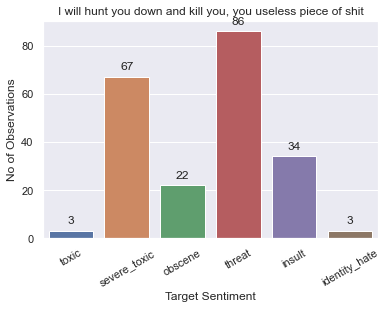

C:\Users\vassi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


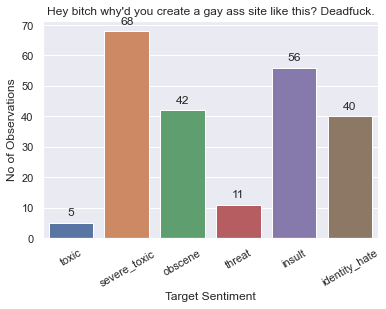

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

assigned_numbers = {0: 'toxic', 1: 'severe_toxic', 2: 'obscene', 3: 'threat', 4: 'insult', 5: 'identity_hate'}
sns.set_theme(style="darkgrid")

columns = list(data.columns)[1:-1]
for column in columns:
    data_copy = data.explode(column)
    data_copy[column] = data_copy[column].map(assigned_numbers)
    splot = sns.countplot(data_copy[column], order=list(assigned_numbers.values()))
    plt.title(dict_questions[column])

    splot.set(xlabel='Target Sentiment', ylabel='No of Observations')
    splot.set_xticklabels(splot.get_xticklabels(), rotation=30)

    for p in splot.patches:
        splot.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
    plt.show()

<h3>Compare the data provided by LoL players and non-players

In [50]:
data = data.explode('Introduction + Q1')
lol, non = [x for _, x in data.groupby(data['Introduction + Q1'])]
lol = lol.drop(['Introduction + Q1', 'Q25'], axis=1)
non = non.drop(['Introduction + Q1', 'Q25'], axis=1)
assigned_numbers = {0: 'toxic', 1: 'severe_toxic', 2: 'obscene', 3: 'threat', 4: 'insult', 5: 'identity_hate'}

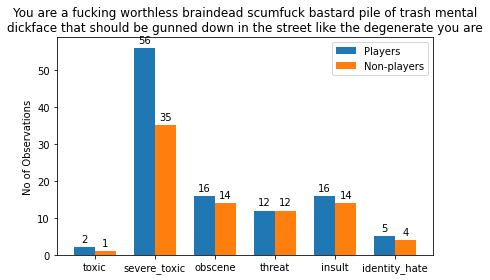

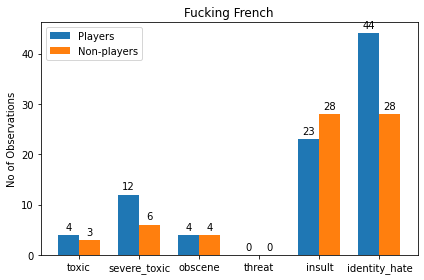

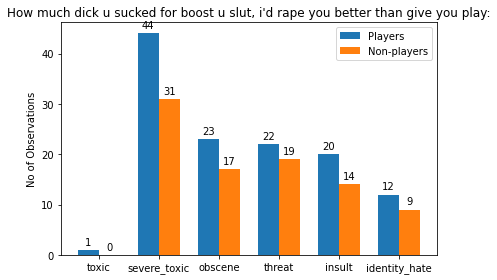

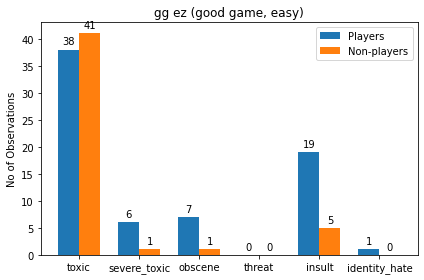

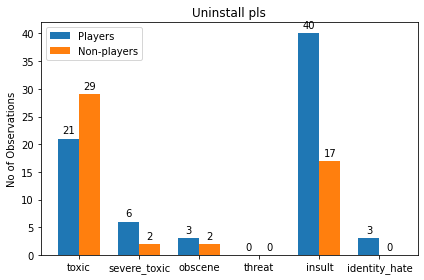

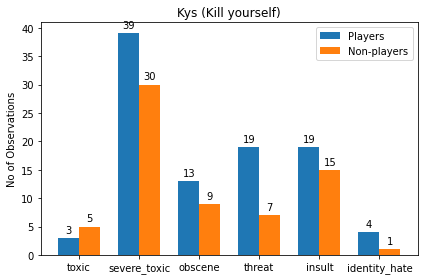

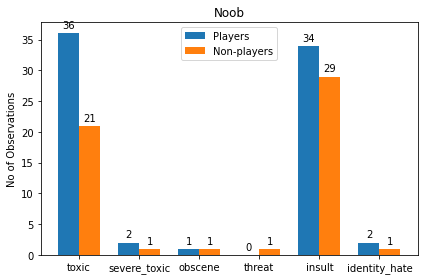

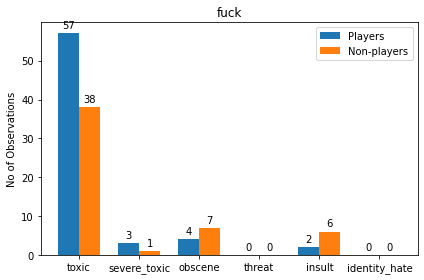

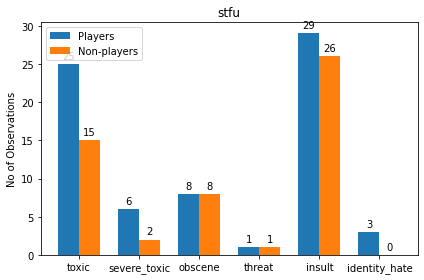

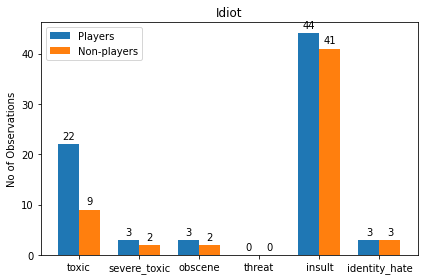

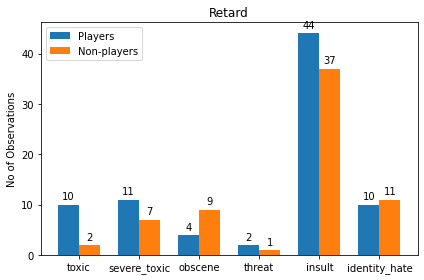

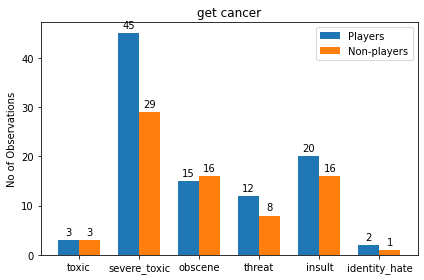

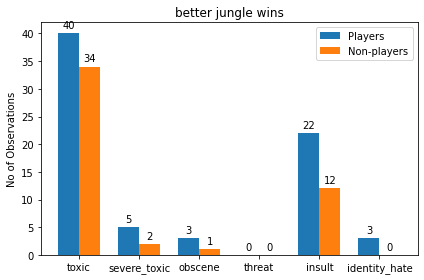

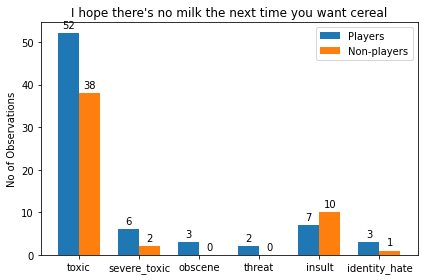

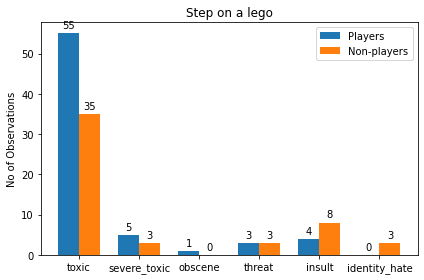

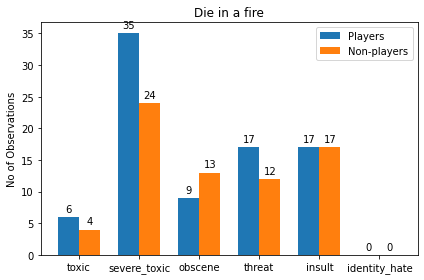

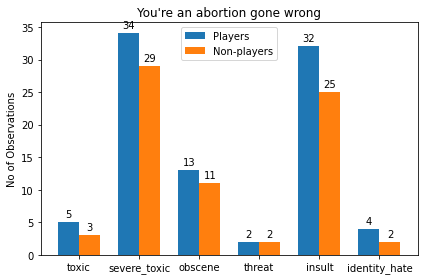

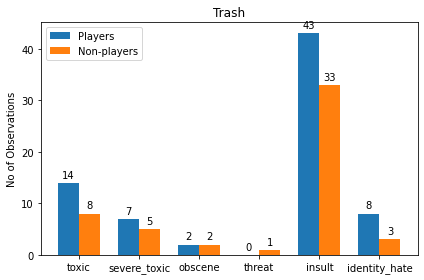

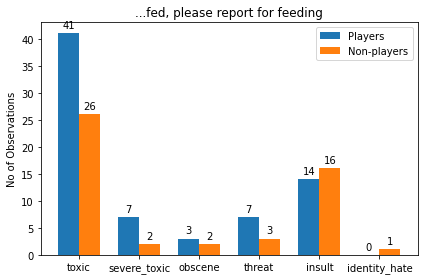

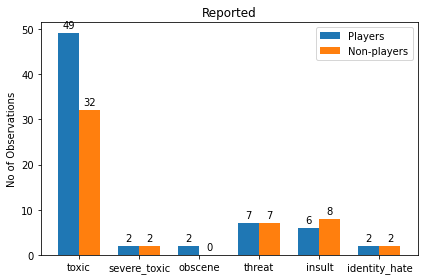

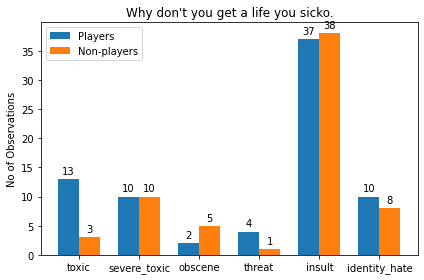

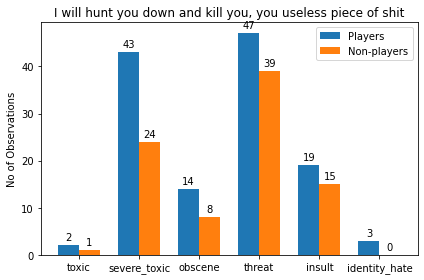

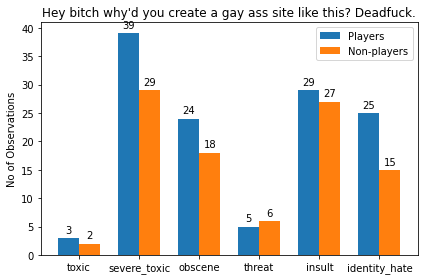

In [51]:
columns = lol.columns
for column in columns:
    
    lol_copy = lol.explode(column)
    non_copy = non.explode(column)
    lol_copy[column] = lol_copy[column].map(assigned_numbers)
    non_copy[column] = non_copy[column].map(assigned_numbers)
    
    labels = list(assigned_numbers.values())
    lol_nums = []
    non_nums = []
    
    for label in labels:
        lol_nums.append(len(lol_copy[lol_copy[column] == label]))
        non_nums.append(len(non_copy[non_copy[column] == label]))

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, lol_nums, width, label='Players')
    rects2 = ax.bar(x + width/2, non_nums, width, label='Non-players')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('No of Observations')
    ax.set_title(dict_questions[column])
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()


    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')


    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()

    plt.show()